# Team E - Pixels plus domain knowledge to True Shower parameters with CNNs

## Team Members

* Bjarne Karsten (3559535)
* Marek Freunscht (9604914)
* Florian Hartung (6622800)

## Data and Example Download
[...]

* an exemplary jupyter notebook and futher information is available from the git repo https://github.com/astrojarred/magic-ml-images
    * You find more information there. 


## TASK 

* Improve your understanding of the data 
* The focus of this teams is the setup of MLPs or CNNs and combining them with domain knowledge like the hillas parameters
* Use the pixel information features starting "clean_image" and the features starting with "hillas" and "stereo"
    * they contain information of all the pixels for a simulated particle
        * "clean_image" contains the data after some some standard cleaning algorithms were applied. These data are used in the MAGIC analysis to derive the Hillas Parameters.
        * "hillas" and "stereo" features are derived from the raw images by using the standard MAGIC analysis workflow. 
* Create a baseline using a simple ML algorithm to
    * classify gammas and protons 
        * by combining both clean_image_\* features
        * by combining both clean_image_\* features with "hillas" and/or "stereo" 
    * predict/infer the true shower parameters using a simple ML algorithm
        * using clean_image\_\*\_m1 and clean_image\_\*\_m2 independently
        * by combining both clean_image_\* features with "hillas" and/or "stereo" 
* Use MLP and simple CNN networks following the same strategy as above to
    * classify gammas and protons 
    * predict/infer true shower parameters using a simple ML algorithm
    * Think about a method to reuse the existing CNN kernels instead of using a hexagonal approch
* compare the different approaches 




## Implementation

### Project Overview
This notebook contains a number of different models each with different parameters and input features.
To save system resources we initialize global state and read all datasets once at the start of the notebook.
From that point on our notebook is split in multiple parts, where every part can be run separately:
- Strategies: Explanations and visualizations for hexagonal images and its conversion to traditional 2d images.
- Classification models: This section contains classification-specific data preprocessing, all classification models and comparisons for all classification models.
- Regression models: This section contains regression-specific data preprocessing, all regression models and comparison for all regression models.

We designed our notebook in such a way, that one can train, save or load individual models just by setting configuration variables (e.g. `SAVE_MODELS_AFTER_TRAINING`).
All outputs in this model are pre-generated and this notebook also comes with pre-trained models which reside in `./trained_models`.

Most functionality is not implemented in this notebook, but rather in the `src` module.
Here is a rough outline of our module structure:
- `Team E.ipynb` **(this notebook)**
- `src/`
    - `common/`: Common python modules for this notebook and other modules
        - `__init__.py`: Common constants such as lists of feature groups, e.g. `FEATURES_HILLAS`, `FEATURES_STEREO` or `FEATURES_IMAGE_M1`.
        - `data_loading.py`: Logic for loading data from `parquet` files. We also read files in batches and flatten all images into columns of floats here.
        - `preprocessing.py`: Logic for preprocessing and splitting data into train, validation and test data.
        - `HexaToParallelogramm.py`: A torch module for converting hexagonal images to 2d images.
        - `visualizations.py`: A collection of functions for logging and plotting to achieve consistent style between models.
        - `batch.py`: TODO
    - `classification_gammas_protons/`
        - `baseline/`: A collection of baseline models for classification.
        - `mlp.py`: A model that uses a multi-layer-perceptron (MLP) for classification.
        - `cnn.py`: A model that uses CNNs for classification.
    - `infer_true_shower_parameters/`
        - `baseline/`: A collection of baseline models for inferring true shower parameters.
        - `mlp.py`: A model that uses a multi-layer-perceptron (MLP) for inferring true shower parameters.
        - `cnn.py`: A model that uses CNNs for inferring true shower parameters.

### Initialize notebook
This code does global initialization.
First it loads the `magicdl` module, which resides in `./magic-ml-images` (from <https://github.com/astrojarred/magic-ml-images>).
Then it sets global configuration variables and chooses an appropriate torch device.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import torch

# Load magicdl module
module_path = str(Path.cwd() / "magic-ml-images")
if module_path not in sys.path:
    sys.path.append(module_path)
import magicdl.magic

# The parent directory of all dataset parquet files
# Note: Currently we only `magic-protons.parquet` and `magic-gammas-new-4.parquet`
DATA_DIR = Path.cwd() / "data"

# The parent directory of where trained models are saved to and loaded from
TRAINED_MODELS_DIR = Path.cwd() / "trained_models"
TRAINED_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Whether models trained from this notebook are saved automatically
SAVE_MODELS_AFTER_TRAINING = True

# Select torch device globally. This is later passed to all model functions
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using torch device '{torch_device}'")

# The seed used for all RNG in data preprocessing and models.
# IMPORTANT: When this seed is changed, one must not load any models trained
#            and saved with a previous different seed. Doing so would violate
#            the ML process, because the previous training/validation data
#            could now end up in the test dataset.
#
# Note: We tried to make everything reproducible and deterministic, however we were
#       not able to do so, due to a lack of understanding of torch's internals.
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

Using torch device 'cuda:0'


### Dataloading
We have defined a module for loading both proton and gamma datasets.
Our dataloading also flattens the image columns, so that every image column is converted to 1039 (number of pixels) individual float columns.
This allows to use image data more easily, as we can now index into the dataframe by specifying all image column names.

In [2]:
from src.common import *
from src.common.data_loading import load_dataset_and_flatten_images

# We choose to only load relevant images and features to save memory
FEATURES_TO_LOAD = FEATURES_HILLAS + FEATURES_STEREO + FEATURES_TRUE_SHOWER
IMAGES_TO_LOAD = ["clean_image_m1", "clean_image_m2"]

# Load the datasets
data_gammas_raw = load_dataset_and_flatten_images(
    DATA_DIR / "magic-gammas-new-4.parquet", IMAGES_TO_LOAD, FEATURES_TO_LOAD
)
data_protons_raw = load_dataset_and_flatten_images(
    DATA_DIR / "magic-protons.parquet", IMAGES_TO_LOAD, FEATURES_TO_LOAD
)

print(f"Number of loaded datapoints: gammas={len(data_gammas_raw)} protons={len(data_protons_raw)}")

Number of loaded datapoints: gammas=192795 protons=105174


### Strategies

For the CNNs used later on, the hexagon needs to be brought in a convolvable shape. To achieve this, we complete it to a parallelogram. This way, we can convolve along the horizontal and the diagonal.

In [3]:
lt = magicdl.magic.Geometry.lookup_table()
qs, rs = (list(t) for t in zip(*lt.keys()))

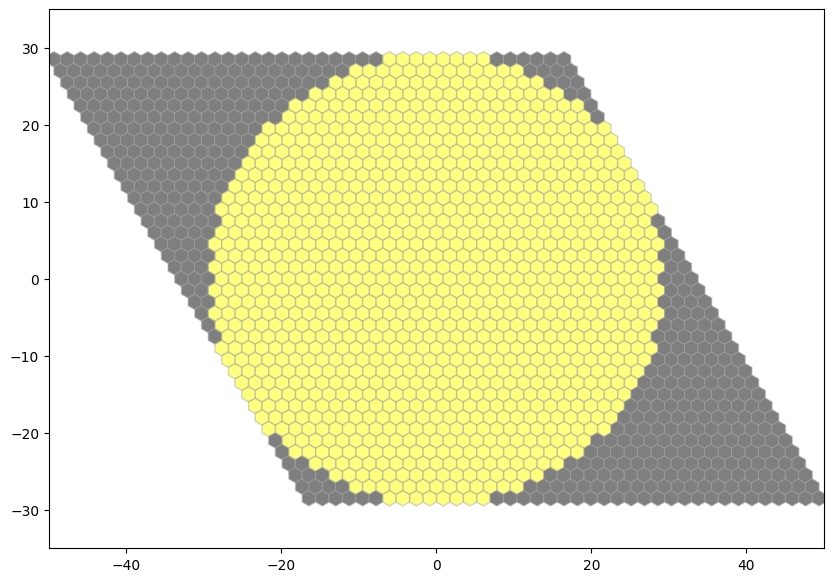

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

figsize = (10, 7)
plt.figure(figsize=figsize)
size = 1

ax = plt.gca()

for q in range(-19, 20):
    for r in range(-19,20):
        ax.add_patch(
            RegularPolygon(
                (magicdl.magic.Geometry.pointy_hex_to_pixel(q,r)),
                6,
                radius=size,
                facecolor= "yellow" if (q,r) in lt.keys() else "black",
                edgecolor="darkgray",
                alpha=0.5,
            )
        )
plt.xlim(-50, 50)
plt.ylim(-35, 35)
plt.show()

We implement a torch layer that takes tensor where the pixels are given along one dimension and passes forth a tensor where they are given two-dimensionally. The image is first filled with a given padding value. Then the given pixel values are filled in according to the logic of the magicdl module. Here q and r, the hexagonal coordinates, are reinterpreted as x and y. In the following, the padding is negative for visualisation purposes:

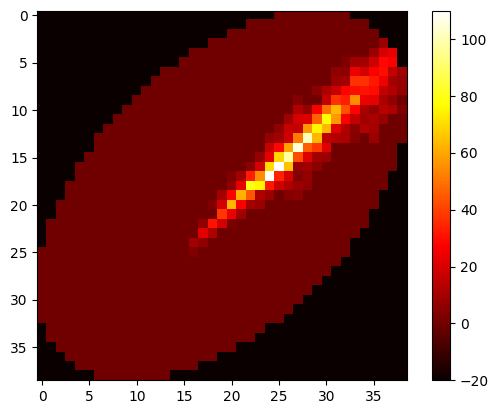

In [8]:
from src.common.HexaToParallelogram import HexaToParallelogram

p = torch.tensor(data_protons_raw[FEATURES_CLEAN_IMAGE_M1].iloc[0].tolist())

h = HexaToParallelogram(0, -20)
result = h.forward(p)

plt.imshow(result.numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

### Data preprocessing for classification models
_Note: This cell need to be run only when training, evaluating or comparing classification models. It is not required for regression models. Restarting the Jupyter Kernel might reduce system resource usage when switching between classification and regression models._

This does preprocessing specific to classification. That includes adding class labels, concatenating both class datasets and normalizing parameters across both combined datasets.

In [3]:
from src.common.preprocessing import preprocess
import pandas as pd

# Assign binary class labels
data_gammas_raw["class"] = 0.0
data_protons_raw["class"] = 1.0

# This constant is used to make up for imbalanced training data in each model's loss function
pos_weight = len(data_gammas_raw) / len(data_protons_raw)

# Concat both datasets. There is not need to shuffle, as that will be done by torch's dataloaders automatically
data_classification = pd.concat([data_gammas_raw, data_protons_raw])

# We got the best results when normalizing all features
normalize_params = (
    FEATURES_HILLAS
    + FEATURES_STEREO
    + FEATURES_TRUE_SHOWER
    + FEATURES_CLEAN_IMAGE_M1
    + FEATURES_CLEAN_IMAGE_M2
)

data_classification_train, data_classification_validation, data_classification_test = (
    preprocess(
        data_classification,
        normalize_params=normalize_params,
        stratify_column_name="class",
        train_portion=0.7,
        validation_portion=0.2,
        seed=SEED,
    )
)

### Baseline: Logistic Regression

#### Images m1 + m2 

In [13]:
from src.classification_gammas_protons.baseline import train_logistic_regression
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lr"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2

model = train_logistic_regression(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIM

Training accuracy: 0.6504303125937829
Validation accuracy: 0.6485204427377457


LogisticRegression(C=0.001, max_iter=200)

#### Images m1 + m2 + Hillas

In [14]:
from src.classification_gammas_protons.baseline import train_logistic_regression
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lr_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS

model = train_logistic_regression(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIM

Training accuracy: 0.7429499404629369
Validation accuracy: 0.7412468940591823


LogisticRegression(C=0.001, max_iter=200)

#### Images m1 + m2 + Stereo

In [15]:
from src.classification_gammas_protons.baseline import train_logistic_regression
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lr_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_STEREO

model = train_logistic_regression(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIM

Training accuracy: 0.7646640270288585
Validation accuracy: 0.7569460131014231


LogisticRegression(C=1000.0, max_iter=200)

#### Images m1 + m2 + Hillas + Stereo

In [16]:
from src.classification_gammas_protons.baseline import train_logistic_regression
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lr_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS + FEATURES_STEREO

model = train_logistic_regression(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/teame/miniconda3/envs/MAGICuda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIM

Training accuracy: 0.8056332710533703
Validation accuracy: 0.7961938107070251


LogisticRegression(C=0.1, max_iter=200)

### Baseline: Random Forest

#### Images m1 + m2

In [17]:
from src.classification_gammas_protons.baseline import train_random_forest
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_rf"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2

model = train_random_forest(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.7764939930491689
Validation accuracy: 0.6805398689857691


RandomForestClassifier(max_depth=75, n_estimators=10)

Images m1 + m2 + Hillas

In [4]:
from src.classification_gammas_protons.baseline import train_random_forest
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_rf_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS

model = train_random_forest(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.9791862299969989
Validation accuracy: 0.8386604924327987


RandomForestClassifier(max_depth=75)

Images m1 + m2 + Stereo

In [5]:
from src.classification_gammas_protons.baseline import train_random_forest
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_rf_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_STEREO

model = train_random_forest(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.98181941392296
Validation accuracy: 0.8269708606279648


RandomForestClassifier(max_depth=75, n_estimators=20)

Images m1 + m2 + Hillas + Stereo

In [6]:
from src.classification_gammas_protons.baseline import train_random_forest
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_rf_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS + FEATURES_STEREO

model = train_random_forest(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.9973813373089248
Validation accuracy: 0.8855884346058279


RandomForestClassifier(max_depth=75)

### Baseline: Linear SVC

Here linear SVCs are used to classify the data. The difficult thing about SVCs is to get them to train in reasonable time. For this to happen, the data had to be prepared once again so it could be processed by an SVC. The first processing step is reducing the dimensionality of the image features, because dimensionality is the SVMs biggest curse. The image features are reduced from 1039*2 to 100 features via PCA. Then the additional features (Stereo and/or Hillas) are added if present. Following that, 90% of the dataset is discarded so that the SVM can train on the remaining 10%. It would be too time consuming to have each SVM train on the entire dataset in the hyperparameter optimization.

The decision to train linear SVCs insteal of kernel SVCs was made after testing showed no significant performance benefit of one or the other. This leads to the obvious choice of linear SVCs because they are faster to train.

#### Images m1 + m2

#### Images m1 + m2

In [8]:
from src.classification_gammas_protons.baseline import train_linear_svc
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lsvc"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2

model = train_linear_svc(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.6510164569215876
Validation accuracy: 0.6504799548277809


LinearSVC(C=0.05, tol=0.1)

#### Images m1 + m2 + Hillas

In [9]:
from src.classification_gammas_protons.baseline import train_linear_svc
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lsvc_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2
additional_features = FEATURES_HILLAS

model = train_linear_svc(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
    additional_features=additional_features
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.7445304937076477
Validation accuracy: 0.7368718238283456


LinearSVC(C=0.001, tol=0.1)

#### Images m1 + m2 + Stereo

In [10]:
from src.classification_gammas_protons.baseline import train_linear_svc
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lsvc_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2
additional_features = FEATURES_STEREO

model = train_linear_svc(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
    additional_features=additional_features
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.7348499515972895
Validation accuracy: 0.7368718238283456


LinearSVC(C=0.05, tol=0.01)

Images m1 + m2 + Hillas + Stereo

In [11]:
from src.classification_gammas_protons.baseline import train_linear_svc
from src.classification_gammas_protons import baseline

THIS_MODEL_NAME = "classification_baseline_lsvc_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2
additional_features = FEATURES_HILLAS + FEATURES_STEREO

model = train_linear_svc(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
    additional_features=additional_features
)

if SAVE_MODELS_AFTER_TRAINING:
    baseline.save(model, trained_model_path)

model

Training accuracy: 0.8034849951597289
Validation accuracy: 0.8018068887634106


LinearSVC(C=1000.0)

### Model: Classification with MLP
This model uses a fully-connected neural network to classify protons and gamma particles.
It concatenates both cleaned images (`clean_image_m1` & `clean_image_m2`) and feeds those into the input layer. This input layer leads into two hidden layers which result into a singular scalar output layer.

This model uses rectified linear units (ReLU) as activation functions between all layers.

To prevent overfitting, a combination of Dropout and Batch Normalization is used before the hidden layers. From experimenting with different values, a dropout rate of 0.1 or 0.2 has yielded the best results.

The final layer does not use a sigmoid function itself, as this is not recommended for binary classification (https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Epoch 1/2 (took 11.9s) - TRAIN(loss|acc): 0.84|61.95% - VALID(loss|acc): 0.66|62.08%
Epoch 2/2 (took 12.1s) - TRAIN(loss|acc): 0.80|65.21% - VALID(loss|acc): 0.59|67.40%


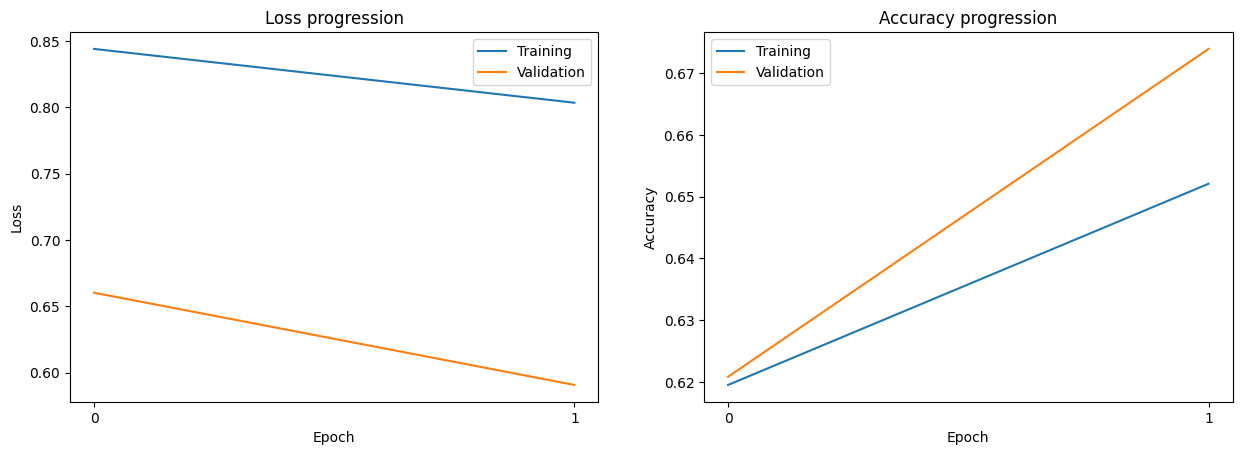

In [5]:
import src.classification_gammas_protons.mlp as classification_mlp

THIS_MODEL_NAME = "classification_mlp"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2

model = classification_mlp.train(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
    pos_weight=pos_weight,
    device=torch_device,
    epochs=2,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_mlp.save(model, trained_model_path)

Epoch 1/2 (took 12.7s) - TRAIN(loss|acc): 0.64|75.66% - VALID(loss|acc): 0.42|81.03%
Epoch 2/2 (took 11.6s) - TRAIN(loss|acc): 0.55|79.90% - VALID(loss|acc): 0.40|81.82%


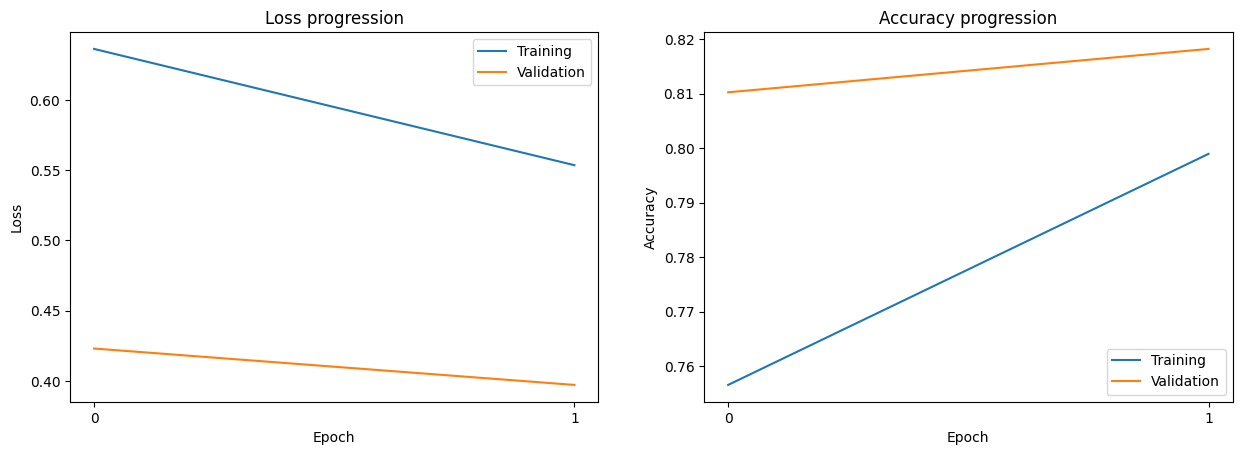

In [6]:
import src.classification_gammas_protons.mlp as classification_mlp

THIS_MODEL_NAME = "classification_mlp_with_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS

model = classification_mlp.train(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
    pos_weight=pos_weight,
    device=torch_device,
    epochs=2,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_mlp.save(model, trained_model_path)

Epoch 1/2 (took 13.0s) - TRAIN(loss|acc): 0.72|74.82% - VALID(loss|acc): 0.54|76.61%
Epoch 2/2 (took 12.7s) - TRAIN(loss|acc): 0.67|77.06% - VALID(loss|acc): 0.52|75.56%


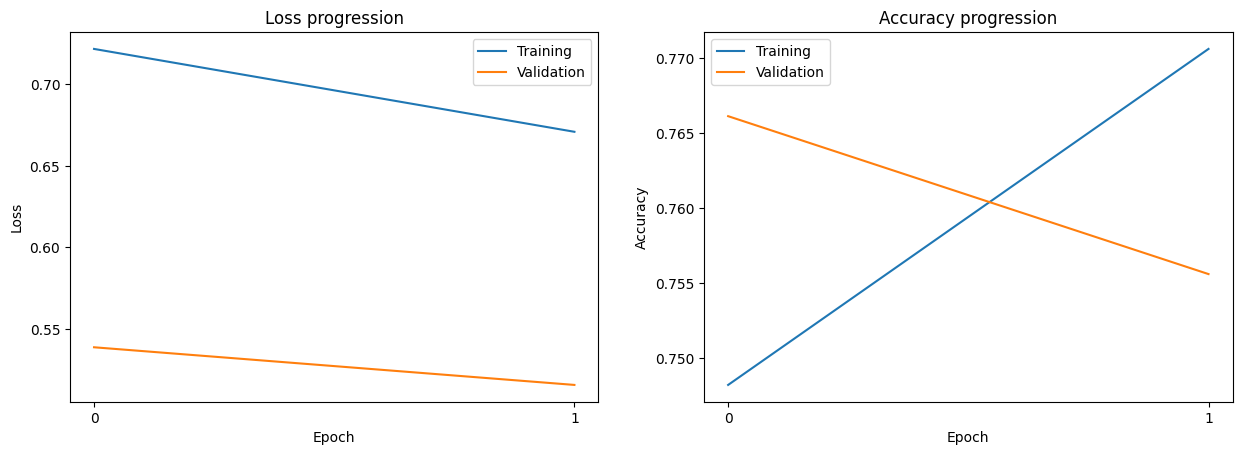

In [7]:
import src.classification_gammas_protons.mlp as classification_mlp

THIS_MODEL_NAME = "classification_mlp_with_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_STEREO

model = classification_mlp.train(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
    pos_weight=pos_weight,
    device=torch_device,
    epochs=2,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_mlp.save(model, trained_model_path)

Epoch 1/20 (took 11.9s) - TRAIN(loss|acc): 0.55|82.23% - VALID(loss|acc): 0.35|86.47%
Epoch 2/20 (took 11.8s) - TRAIN(loss|acc): 0.47|85.93% - VALID(loss|acc): 0.33|87.14%
Epoch 3/20 (took 12.1s) - TRAIN(loss|acc): 0.45|86.79% - VALID(loss|acc): 0.31|88.08%
Epoch 4/20 (took 11.8s) - TRAIN(loss|acc): 0.43|87.12% - VALID(loss|acc): 0.32|87.90%
Epoch 5/20 (took 11.8s) - TRAIN(loss|acc): 0.42|87.44% - VALID(loss|acc): 0.31|87.79%
Epoch 6/20 (took 12.3s) - TRAIN(loss|acc): 0.41|87.60% - VALID(loss|acc): 0.31|87.99%
Epoch 7/20 (took 12.0s) - TRAIN(loss|acc): 0.40|87.95% - VALID(loss|acc): 0.31|88.01%
Epoch 8/20 (took 12.5s) - TRAIN(loss|acc): 0.40|88.13% - VALID(loss|acc): 0.32|87.26%
Epoch 9/20 (took 12.5s) - TRAIN(loss|acc): 0.39|88.29% - VALID(loss|acc): 0.34|86.35%
Epoch 10/20 (took 12.6s) - TRAIN(loss|acc): 0.38|88.41% - VALID(loss|acc): 0.31|87.59%
Epoch 11/20 (took 12.4s) - TRAIN(loss|acc): 0.38|88.53% - VALID(loss|acc): 0.34|86.19%
Epoch 12/20 (took 13.1s) - TRAIN(loss|acc): 0.38|88.

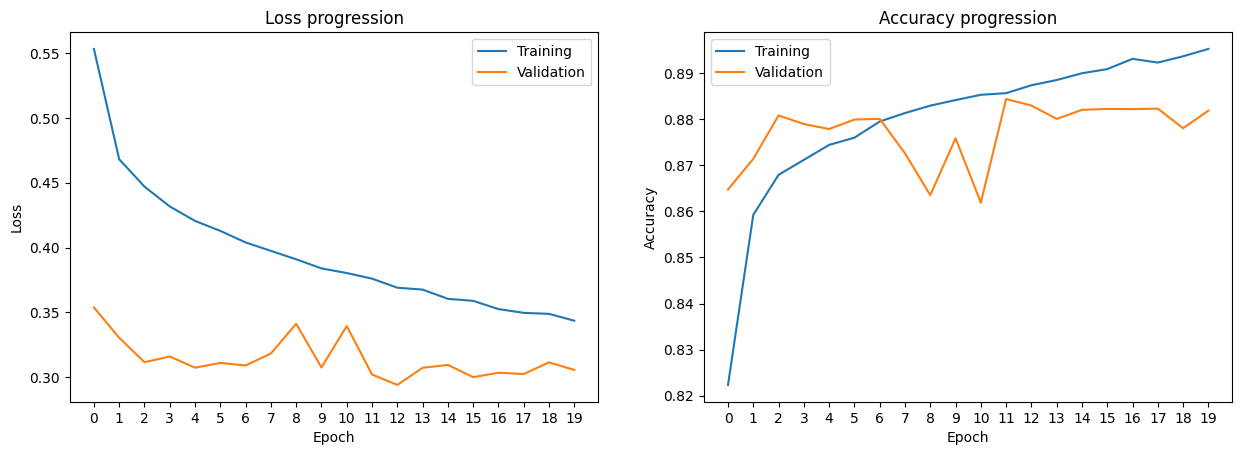

In [9]:
import src.classification_gammas_protons.mlp as classification_mlp

THIS_MODEL_NAME = "classification_mlp_with_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS + FEATURES_STEREO

model = classification_mlp.train(
    data_classification_train,
    data_classification_validation,
    features=features,
    class_feature="class",
    pos_weight=pos_weight,
    device=torch_device,
    epochs=20,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_mlp.save(model, trained_model_path)

### Model: Classification with CNN
This model uses a CNN combined with a fully-connected neural network to classify protons and gamma particles.

It feeds both cleaned images (`clean_image_m1` & `clean_image_m2`) into a CNN with two convolutional, two ReLU and two max-pooling layers.

Then the CNN's outputs are passed to a fully-connected neural network.
For 3 of the 4 variants of this model we also concatenate the CNN's output and some additional features such as the hillas, stereo or hillas + stereo parameters.
We do this, because those additional features have not spacial relations between each other and thus passing them through a CNN would not make sense.

The fully-connected neural network (FCNN) consists of 3 layers and two ReLU activations after the first 2 layers.
Similar to the MLP this FCNN also uses no activation function in its last layer, because using one is not recommended for our binary classification loss function [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Epoch 1/25 (took 48.5s) - TRAIN(loss|acc): 0.64|73.05% - VALID(loss|acc): 0.39|82.32%
Epoch 2/25 (took 48.6s) - TRAIN(loss|acc): 0.50|82.38% - VALID(loss|acc): 0.40|81.39%
Epoch 3/25 (took 48.0s) - TRAIN(loss|acc): 0.47|83.91% - VALID(loss|acc): 0.34|85.35%
Epoch 4/25 (took 48.3s) - TRAIN(loss|acc): 0.45|84.71% - VALID(loss|acc): 0.34|85.58%
Epoch 5/25 (took 47.4s) - TRAIN(loss|acc): 0.44|85.20% - VALID(loss|acc): 0.33|85.31%
Epoch 6/25 (took 47.5s) - TRAIN(loss|acc): 0.43|85.72% - VALID(loss|acc): 0.33|85.94%
Epoch 7/25 (took 48.4s) - TRAIN(loss|acc): 0.42|86.04% - VALID(loss|acc): 0.32|86.50%
Epoch 8/25 (took 46.9s) - TRAIN(loss|acc): 0.41|86.47% - VALID(loss|acc): 0.32|86.45%
Epoch 9/25 (took 44.4s) - TRAIN(loss|acc): 0.40|86.60% - VALID(loss|acc): 0.31|86.68%
Epoch 10/25 (took 45.8s) - TRAIN(loss|acc): 0.39|86.94% - VALID(loss|acc): 0.33|85.42%
Epoch 11/25 (took 46.0s) - TRAIN(loss|acc): 0.39|87.19% - VALID(loss|acc): 0.33|85.78%
Epoch 12/25 (took 49.2s) - TRAIN(loss|acc): 0.38|87.

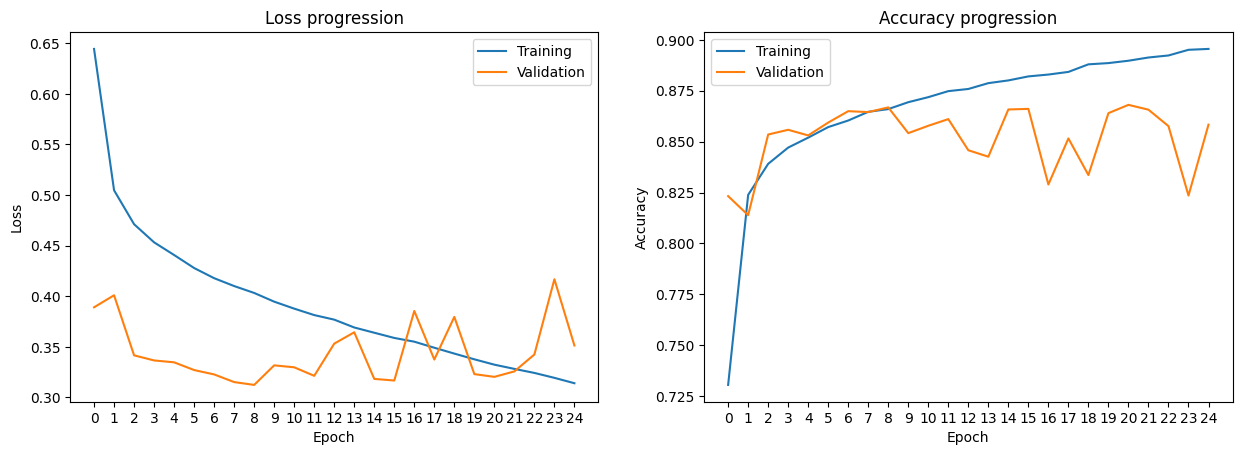

In [5]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

THIS_MODEL_NAME = "classification_cnn"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = classification_cnn.train(
    data_classification_train,
    data_classification_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    class_feature="class",
    device=torch_device,
    pos_weight=pos_weight,
    epochs=25,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_cnn.save(model, trained_model_path)

Epoch 1/25 (took 41.1s) - TRAIN(loss|acc): 0.51|81.42% - VALID(loss|acc): 0.35|83.67%
Epoch 2/25 (took 39.0s) - TRAIN(loss|acc): 0.43|85.53% - VALID(loss|acc): 0.32|85.88%
Epoch 3/25 (took 39.0s) - TRAIN(loss|acc): 0.40|86.91% - VALID(loss|acc): 0.30|87.27%
Epoch 4/25 (took 39.3s) - TRAIN(loss|acc): 0.38|87.46% - VALID(loss|acc): 0.28|88.16%
Epoch 5/25 (took 39.0s) - TRAIN(loss|acc): 0.37|87.89% - VALID(loss|acc): 0.32|85.48%
Epoch 6/25 (took 38.6s) - TRAIN(loss|acc): 0.36|88.26% - VALID(loss|acc): 0.28|87.77%
Epoch 7/25 (took 38.7s) - TRAIN(loss|acc): 0.35|88.49% - VALID(loss|acc): 0.29|87.87%
Epoch 8/25 (took 39.0s) - TRAIN(loss|acc): 0.34|88.73% - VALID(loss|acc): 0.30|87.06%
Epoch 9/25 (took 38.8s) - TRAIN(loss|acc): 0.33|89.00% - VALID(loss|acc): 0.27|88.62%
Epoch 10/25 (took 39.1s) - TRAIN(loss|acc): 0.33|89.30% - VALID(loss|acc): 0.29|87.31%
Epoch 11/25 (took 39.1s) - TRAIN(loss|acc): 0.32|89.42% - VALID(loss|acc): 0.30|87.03%
Epoch 12/25 (took 39.2s) - TRAIN(loss|acc): 0.31|89.

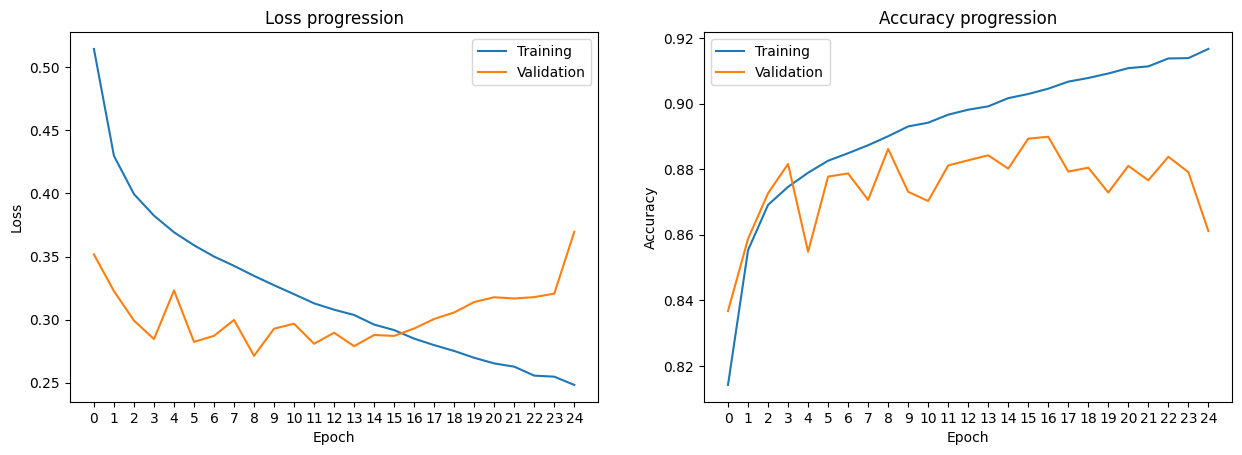

In [4]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

THIS_MODEL_NAME = "classification_cnn_with_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = classification_cnn.train(
    data_classification_train,
    data_classification_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    class_feature="class",
    device=torch_device,
    pos_weight=pos_weight,
    epochs=25,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_cnn.save(model, trained_model_path)

Epoch 1/25 (took 38.8s) - TRAIN(loss|acc): 0.58|79.92% - VALID(loss|acc): 0.35|85.77%
Epoch 2/25 (took 39.4s) - TRAIN(loss|acc): 0.45|85.28% - VALID(loss|acc): 0.33|86.02%
Epoch 3/25 (took 39.3s) - TRAIN(loss|acc): 0.42|86.63% - VALID(loss|acc): 0.30|87.38%
Epoch 4/25 (took 39.3s) - TRAIN(loss|acc): 0.40|87.42% - VALID(loss|acc): 0.31|87.10%
Epoch 5/25 (took 39.5s) - TRAIN(loss|acc): 0.39|87.79% - VALID(loss|acc): 0.29|88.07%
Epoch 6/25 (took 40.4s) - TRAIN(loss|acc): 0.37|88.19% - VALID(loss|acc): 0.29|88.05%
Epoch 7/25 (took 39.5s) - TRAIN(loss|acc): 0.36|88.58% - VALID(loss|acc): 0.33|86.24%
Epoch 8/25 (took 39.2s) - TRAIN(loss|acc): 0.35|88.78% - VALID(loss|acc): 0.31|87.49%
Epoch 9/25 (took 39.9s) - TRAIN(loss|acc): 0.35|88.98% - VALID(loss|acc): 0.30|87.95%
Epoch 10/25 (took 39.2s) - TRAIN(loss|acc): 0.34|89.26% - VALID(loss|acc): 0.31|87.70%
Epoch 11/25 (took 38.3s) - TRAIN(loss|acc): 0.33|89.47% - VALID(loss|acc): 0.30|88.15%
Epoch 12/25 (took 39.5s) - TRAIN(loss|acc): 0.32|89.

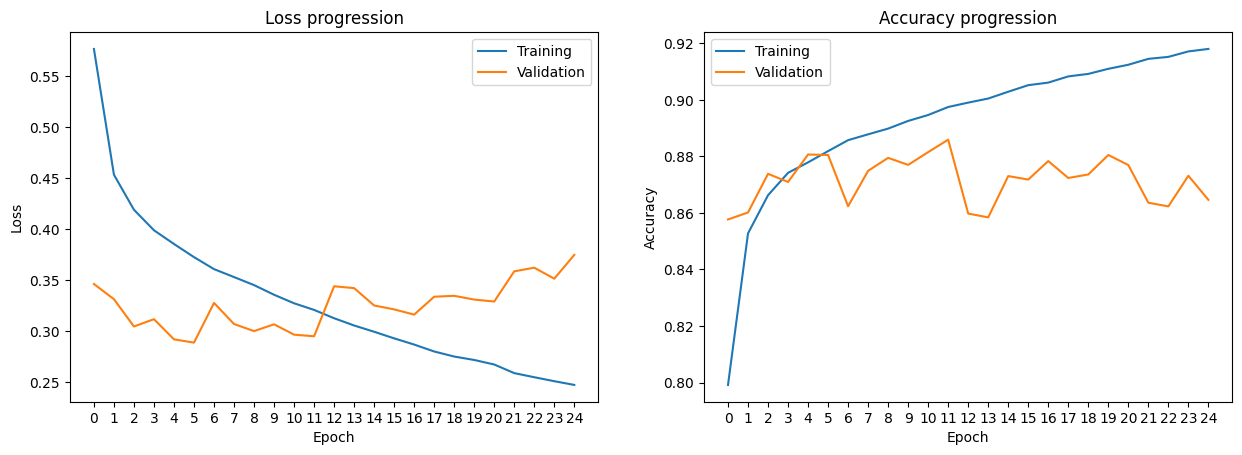

In [5]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

THIS_MODEL_NAME = "classification_cnn_with_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = classification_cnn.train(
    data_classification_train,
    data_classification_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    class_feature="class",
    device=torch_device,
    pos_weight=pos_weight,
    epochs=25,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_cnn.save(model, trained_model_path)

Epoch 1/25 (took 39.2s) - TRAIN(loss|acc): 0.43|86.58% - VALID(loss|acc): 0.31|87.24%
Epoch 2/25 (took 39.4s) - TRAIN(loss|acc): 0.38|88.31% - VALID(loss|acc): 0.29|88.08%
Epoch 3/25 (took 40.0s) - TRAIN(loss|acc): 0.35|88.94% - VALID(loss|acc): 0.26|89.28%
Epoch 4/25 (took 39.4s) - TRAIN(loss|acc): 0.34|89.47% - VALID(loss|acc): 0.25|89.65%
Epoch 5/25 (took 39.5s) - TRAIN(loss|acc): 0.33|89.80% - VALID(loss|acc): 0.28|88.62%
Epoch 6/25 (took 39.5s) - TRAIN(loss|acc): 0.32|90.22% - VALID(loss|acc): 0.26|89.46%
Epoch 7/25 (took 39.4s) - TRAIN(loss|acc): 0.30|90.57% - VALID(loss|acc): 0.26|89.44%
Epoch 8/25 (took 38.5s) - TRAIN(loss|acc): 0.30|90.77% - VALID(loss|acc): 0.24|90.11%
Epoch 9/25 (took 38.3s) - TRAIN(loss|acc): 0.29|91.02% - VALID(loss|acc): 0.25|90.13%
Epoch 10/25 (took 39.9s) - TRAIN(loss|acc): 0.28|91.26% - VALID(loss|acc): 0.25|89.72%
Epoch 11/25 (took 39.8s) - TRAIN(loss|acc): 0.27|91.44% - VALID(loss|acc): 0.25|89.79%
Epoch 12/25 (took 38.6s) - TRAIN(loss|acc): 0.26|91.

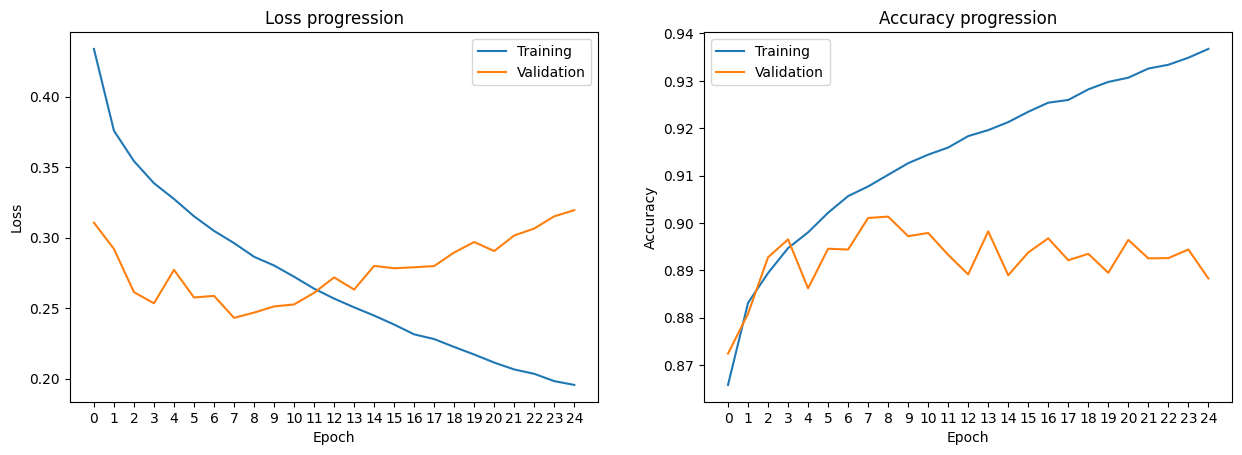

In [6]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

THIS_MODEL_NAME = "classification_cnn_with_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = classification_cnn.train(
    data_classification_train,
    data_classification_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    class_feature="class",
    device=torch_device,
    pos_weight=pos_weight,
    epochs=25,
)

if SAVE_MODELS_AFTER_TRAINING:
    classification_cnn.save(model, trained_model_path)

### Comparison of classification models
This section loads all classification models and evaluates them on the test dataset.
All accuracies are output for each model and different variations of input features (none, hillas, stereo, hillas + stereo).

Note: These accuracies are not to be used to optimize models, as this would respect the ML process.

In [4]:
from src.classification_gammas_protons import (
    cnn as classification_cnn,
    mlp as classification_mlp,
    baseline,
)
import numpy as np
from typing import Optional, Tuple
from sklearn.svm import LinearSVC
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def evaluate_classification_baseline_model(
    model_name: str, features: list[str], additional_features: list[str]
) -> pd.DataFrame | str:
    path = TRAINED_MODELS_DIR / f"{model_name}.pth"
    if not path.exists():
        return str(path)

    model = baseline.load(path)

    if isinstance(model, LinearSVC):
        pca = model.pca
        images = data_classification_test[features]
        images = pca.transform(images)
        additional = data_classification_test[additional_features]

        X_test = np.concatenate([images, additional], axis=1)
    else:
        X_test = data_classification_test[features + additional_features]

    y_test = data_classification_test[["class"]]

    return baseline.predict(
        model,
        X_test,
    )


def evaluate_classification_mlp_model(
    model_name: str, features: list[str]
) -> pd.DataFrame | str:
    path = TRAINED_MODELS_DIR / f"{model_name}.pth"
    if not path.exists():
        return str(path)

    model = classification_mlp.load(path, len(features), torch_device)

    return classification_mlp.predict(
        model, torch_device, data_classification_test, features
    )


def evaluate_classification_cnn_model(
    model_name: str, additional_features: list[str]
) -> pd.DataFrame | str:
    path = TRAINED_MODELS_DIR / f"{model_name}.pth"
    if not path.exists():
        return str(path)

    model = classification_cnn.load(path, additional_features, torch_device)

    return classification_cnn.predict(
        model,
        data_classification_test,
        [FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
        additional_features,
        torch_device,
    )


results = [
    evaluate_classification_baseline_model(
        "classification_baseline_lr",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        [],
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_lr_hillas",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_HILLAS,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_lr_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_STEREO,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_lr_hillas_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_HILLAS + FEATURES_STEREO,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_rf",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        [],
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_rf_hillas",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_HILLAS,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_rf_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_STEREO,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_rf_hillas_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_HILLAS + FEATURES_STEREO,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_lsvc",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        [],
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_lsvc_hillas",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_HILLAS,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_lsvc_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_STEREO,
    ),
    evaluate_classification_baseline_model(
        "classification_baseline_lsvc_hillas_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
        FEATURES_HILLAS + FEATURES_STEREO,
    ),
    evaluate_classification_mlp_model(
        "classification_mlp",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
    ),
    evaluate_classification_mlp_model(
        "classification_mlp_with_hillas",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS,
    ),
    evaluate_classification_mlp_model(
        "classification_mlp_with_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_STEREO,
    ),
    evaluate_classification_mlp_model(
        "classification_mlp_with_hillas_stereo",
        FEATURES_CLEAN_IMAGE_M1
        + FEATURES_CLEAN_IMAGE_M2
        + FEATURES_HILLAS
        + FEATURES_STEREO,
    ),
    evaluate_classification_cnn_model("classification_cnn", []),
    evaluate_classification_cnn_model(
        "classification_cnn_with_hillas",
        FEATURES_HILLAS,
    ),
    evaluate_classification_cnn_model(
        "classification_cnn_with_stereo",
        FEATURES_STEREO,
    ),
    evaluate_classification_cnn_model(
        "classification_cnn_with_hillas_stereo",
        FEATURES_HILLAS + FEATURES_STEREO,
    ),
]



def print_table(title: str, scores: pd.DataFrame):
    table = pd.DataFrame(
        np.array(scores).reshape([5, 4]).T,
        [
            "Cleaned images",
            "Cleaned images + Hillas",
            "Cleaned images + Stereo",
            "Cleaned images + Hillas + Stereo",
        ],
        ["LogisticRegression", "RandomForest", "LinearSVC", "MLP", "CNN"],
    )
    print(f"{title}:")
    display(table)


# Print warnings for all models that failed to load
models_not_found = []
results2 = []
for result in results:
    if isinstance(result, str):
        models_not_found.append(result)
        results2.append(None)
    else:
        results2.append(result)
if len(models_not_found) > 0:
    print(f"Warning: Failed to load models {models_not_found}")

accuracy_scores = []
precision_scores = []
recall_scores = []
fbeta_scores = []
for result in results2:
    if result is None:
        accuracy_scores.append("")
        precision_scores.append("")
        recall_scores.append("")
        fbeta_scores.append("")
    else:
        true = data_classification_test[["class"]]
        accuracy = accuracy_score(true, result)
        # Note: we take the average of all scores, because this makes the overall comparison more compact
        precision, recall, fbeta, _ = precision_recall_fscore_support(true, result, average='weighted') 
        accuracy_scores.append(f"{accuracy:.2f}")
        precision_scores.append(f"{precision:.2f}")
        recall_scores.append(f"{recall:.2f}")
        fbeta_scores.append(f"{fbeta:.2f}")


print_table("Accuracy", accuracy_scores)
print_table("Precision", precision_scores)
print_table("Recall", recall_scores)
print_table("F-beta score", fbeta_scores)

Accuracy:


,LogisticRegression,RandomForest,LinearSVC,MLP,CNN
Cleaned images,0.65,,0.65,0.36,0.86
Cleaned images + Hillas,0.74,,0.74,0.37,0.86
Cleaned images + Stereo,0.72,,0.71,0.42,0.86
Cleaned images + Hillas + Stereo,0.77,,0.76,0.64,0.89


Precision:


,LogisticRegression,RandomForest,LinearSVC,MLP,CNN
Cleaned images,0.54,,0.53,0.63,0.86
Cleaned images + Hillas,0.76,,0.77,0.63,0.87
Cleaned images + Stereo,0.74,,0.74,0.64,0.87
Cleaned images + Hillas + Stereo,0.77,,0.76,0.49,0.89


Recall:


,LogisticRegression,RandomForest,LinearSVC,MLP,CNN
Cleaned images,0.65,,0.65,0.36,0.86
Cleaned images + Hillas,0.74,,0.74,0.37,0.86
Cleaned images + Stereo,0.72,,0.71,0.42,0.86
Cleaned images + Hillas + Stereo,0.77,,0.76,0.64,0.89


F-beta score:


,LogisticRegression,RandomForest,LinearSVC,MLP,CNN
Cleaned images,0.52,,0.51,0.20,0.86
Cleaned images + Hillas,0.71,,0.71,0.24,0.86
Cleaned images + Stereo,0.66,,0.66,0.35,0.87
Cleaned images + Hillas + Stereo,0.75,,0.74,0.51,0.89


## Regression of true shower parameters

### Data preprocessing for regression models
_Note: This cell need to be run only when training, evaluating or comparing regression models. It is not required for classification models. Restarting the Jupyter Kernel might reduce system resource usage when switching between classification and regression models._

This does preprocessing specific to regression such as normalizing features for each class dataset individually.

In [3]:
from src.common.preprocessing import preprocess
import pandas as pd

normalize_params = (
    FEATURES_HILLAS
    + FEATURES_STEREO
    + FEATURES_TRUE_SHOWER
    + FEATURES_CLEAN_IMAGE_M1
    + FEATURES_CLEAN_IMAGE_M2
)

(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    data_regression_gammas_test,
) = preprocess(
    data_gammas_raw,
    normalize_params=normalize_params,
    train_portion=0.7,
    validation_portion=0.2,
    seed=SEED,
)

(
    data_regression_protons_train,
    data_regression_protons_validation,
    data_regression_protons_test,
) = preprocess(
    data_protons_raw,
    normalize_params=normalize_params,
    train_portion=0.7,
    validation_portion=0.2,
    seed=SEED,
)

### Baseline: Linear regression for gammas

This is a simple linear regression with one layer. It takes all the inputs, including images, linearly concatenated to one another and has an output size of eight.

#### Using only cleaned image m1

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_gammas_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.94731367
Train R^2:  0.052686453
Validation loss: 0.9621331
Validation R^2:  0.046241343


#### Using only cleaned image m2

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_gammas_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.94568515
Train R^2:  0.05431497
Validation loss: 0.968469
Validation R^2:  0.039960563


#### Using both cleaned images

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_gammas_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.93013847
Train R^2:  0.06986165
Validation loss: 0.9533193
Validation R^2:  0.05497843


#### Using both cleaned images and hillas

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_gammas_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.79175997
Train R^2:  0.20824009
Validation loss: 0.8131913
Validation R^2:  0.19388682


#### Using both cleaned images and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_gammas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.5424412
Train R^2:  0.45755887
Validation loss: 0.55760777
Validation R^2:  0.44724566


#### Using both cleaned images, hillas and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_gammas_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.4588969
Train R^2:  0.5411031
Validation loss: 0.47304952
Validation R^2:  0.53106797


### Baseline: Linear regression for protons
#### Using only cleaned image m1

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_protons_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.97740394
Train R^2:  0.02259618
Validation loss: 1.0031251
Validation R^2:  0.012042224


#### Using only cleaned image m2

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_protons_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.97800964
Train R^2:  0.021990478
Validation loss: 1.0030661
Validation R^2:  0.012100339


#### Using both cleaned images

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_protons_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.9670574
Train R^2:  0.032942712
Validation loss: 1.0016184
Validation R^2:  0.013526082


#### Using both cleaned images and hillas

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_protons_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.890238
Train R^2:  0.10976213
Validation loss: 0.9207937
Validation R^2:  0.09312868


#### Using both cleaned images and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_protons_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.60732573
Train R^2:  0.39267433
Validation loss: 0.6364985
Validation R^2:  0.3731253


#### Using both cleaned images, hillas and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg

THIS_MODEL_NAME = "regression_linear_protons_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = lin_reg.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=1000
)

if SAVE_MODELS_AFTER_TRAINING:
    lin_reg.save(model, trained_model_path)

Train loss: 0.57047135
Train R^2:  0.4295287
Validation loss: 0.59494156
Validation R^2:  0.41405398


### Baseline: Decision Tree for Gammas

This is a simple decision tree regressor (using sklearn's implementation). It has a maximum depth of five, which has been found to be optimal using grid search.

#### Using only cleaned image m1

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_gammas_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.9587755240304497
Train R^2:  0.041224587300960014
Validation loss: 0.9713488951615522
Validation R^2:  0.037105807192004736


#### Using only cleaned image m2

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_gammas_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.9572958699732041
Train R^2:  0.0427042411863906
Validation loss: 0.9704318610173326
Validation R^2:  0.03801485939402416


#### Using both cleaned images

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_gammas_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.9564255647564819
Train R^2:  0.043574546302054484
Validation loss: 0.9686790864511607
Validation R^2:  0.03975237766318096


#### Using both cleaned images and hillas

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_gammas_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.8367483703359367
Train R^2:  0.16325172682588407
Validation loss: 0.848553971429735
Validation R^2:  0.15883191359582405


#### Using both cleaned images and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_gammas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.48360693220093265
Train R^2:  0.5163931239546952
Validation loss: 0.4882804099568692
Validation R^2:  0.5159696237352693


#### Using both cleaned images, hillas and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_gammas_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.4653668772494799
Train R^2:  0.5346331767881433
Validation loss: 0.4712079690946748
Validation R^2:  0.5328934646385226


### Baseline: Decision tree for protons
#### Using only cleaned image m1

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_protons_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.968986683329368
Train R^2:  0.031013421764236937
Validation loss: 0.9979097925074025
Validation R^2:  0.017178629485401276


#### Using only cleaned image m2

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_protons_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.9682137085095476
Train R^2:  0.031786396500222636
Validation loss: 0.9980182062556437
Validation R^2:  0.017071854955850507


#### Using both cleaned images

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_protons_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.9662246671305412
Train R^2:  0.033775437663502994
Validation loss: 0.9949409364633317
Validation R^2:  0.020102596348941737


#### Using both cleaned images and hillas

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_protons_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.9222897157774821
Train R^2:  0.07771038425149945
Validation loss: 0.9417768747986174
Validation R^2:  0.07246281601984916


#### Using both cleaned images and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_protons_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.5290072702706988
Train R^2:  0.47099278710396064
Validation loss: 0.5494484838587648
Validation R^2:  0.45885919149427146


#### Using both cleaned images, hillas and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt

THIS_MODEL_NAME = "regression_decisiontree_protons_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_dt.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS+FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_dt.save(model, trained_model_path)

Train loss: 0.5267759194760706
Train R^2:  0.4732241376565828
Validation loss: 0.5471072103294128
Validation R^2:  0.461165064907023


### Baseline: Random Forest for gammas

This is a random forest baseline regression algorithm (using sklearn's random forest regressor). It has a maximal depth of 20 and 200 trees. These parameters have been found using grid search. While the models seem to be overfitted, pruning did not improve the model's performance and is thus not used.

#### Using only cleaned image m1

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_gammas_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.7082599791213267
Train R^2:  0.29174010312063703
Validation loss: 0.8971111592241031
Validation R^2:  0.11069737164166038


#### Using only cleaned image m2

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_gammas_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.7008024436893933
Train R^2:  0.299197637686614
Validation loss: 0.8952564215239633
Validation R^2:  0.1125359655491045


#### Using both cleaned images

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_gammas_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.6264764661433876
Train R^2:  0.37352360660201156
Validation loss: 0.8176482200989521
Validation R^2:  0.18946865867167995


#### Using both cleaned images and hillas

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_gammas_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.227831544110863
Train R^2:  0.7721684823445547
Validation loss: 0.6272600153371978
Validation R^2:  0.37819970851113327


#### Using both cleaned images and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_gammas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.0766353950723317
Train R^2:  0.9233646138264422
Validation loss: 0.26873636450930183
Validation R^2:  0.7336027393748131


#### Using both cleaned images, hillas and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_gammas_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS+FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.044092349951984945
Train R^2:  0.955907655167945
Validation loss: 0.21810818257454442
Validation R^2:  0.7837902493624542


### Baseline: Random forest for protons
#### Using only cleaned image m1

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_protons_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.7869389407140526
Train R^2:  0.21306114463515968
Validation loss: 0.9637171732806669
Validation R^2:  0.05085425542095379


#### Using only cleaned image m2

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_protons_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.7836955951808805
Train R^2:  0.21630448981656747
Validation loss: 0.9630153539043443
Validation R^2:  0.051545463270069924


#### Using both cleaned images

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_protons_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.7357616668911131
Train R^2:  0.2642384129075541
Validation loss: 0.9241443514850027
Validation R^2:  0.08982873512279121


#### Using both cleaned images and hillas

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_protons_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.47677268150405633
Train R^2:  0.5232273702053848
Validation loss: 0.8613106100215803
Validation R^2:  0.1517124287825895


#### Using both cleaned images and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_protons_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.14940001985640897
Train R^2:  0.8505999963471024
Validation loss: 0.4535255441016308
Validation R^2:  0.5533317739097772


#### Using both cleaned images, hillas and stereo

In [ ]:
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf

THIS_MODEL_NAME = "regression_randomforest_protons_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_rf.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS+FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_rf.save(model, trained_model_path)

Train loss: 0.11301242609919682
Train R^2:  0.8869875861578171
Validation loss: 0.4082190164821104
Validation R^2:  0.5979532656544273


### Using MLP for Gammas

This is a multi layer perceptron that takes the data in a one-dimensional form with hillas/stereo features appended to the image features, just like it has been done before in the baseline. It has five layers, with the first three having the size of 256, and then decreasing towards eight (the output size). It uses ReLU activation and batch normalisation. 

#### Using only cleaned image m1

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


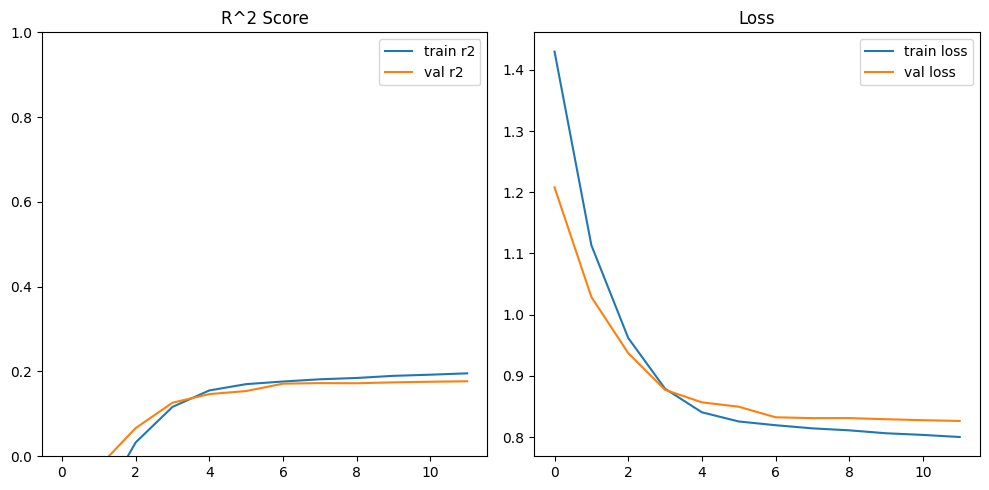

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_gammas_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using only cleaned image m2

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


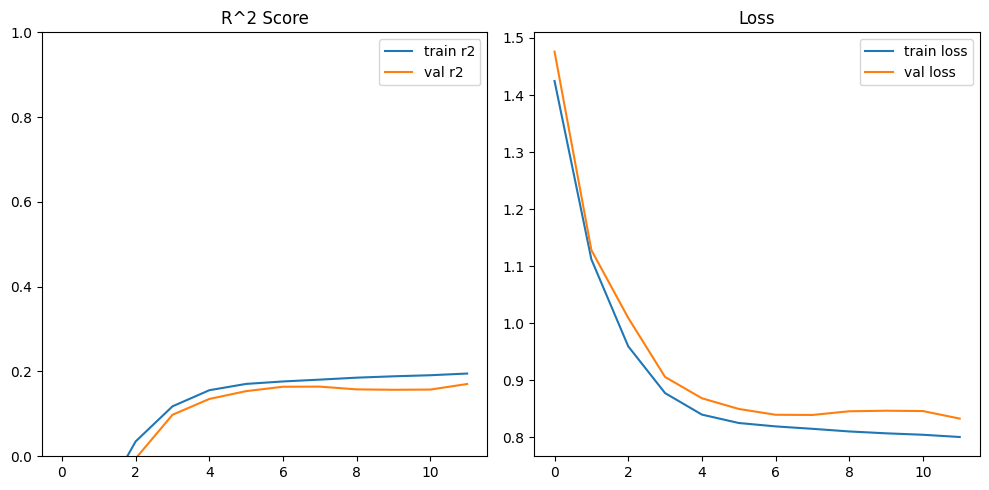

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_gammas_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


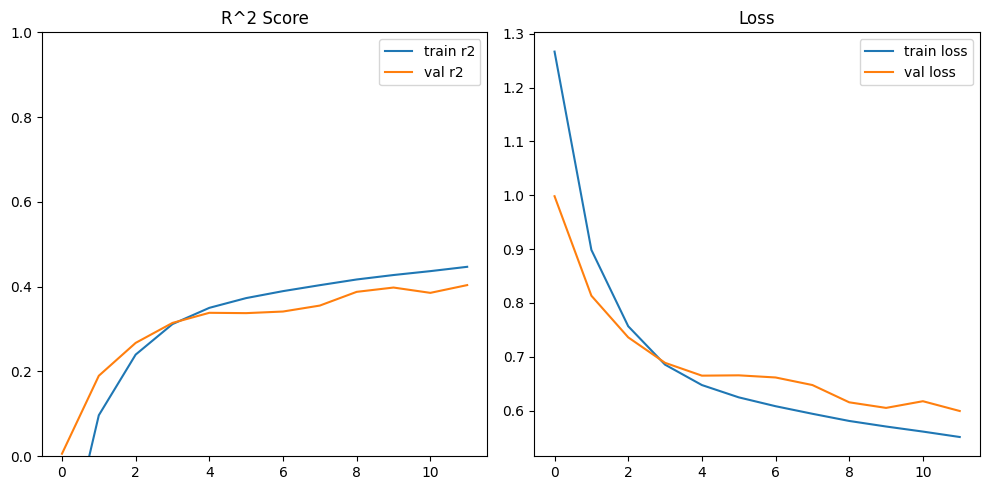

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_gammas_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images and hillas

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


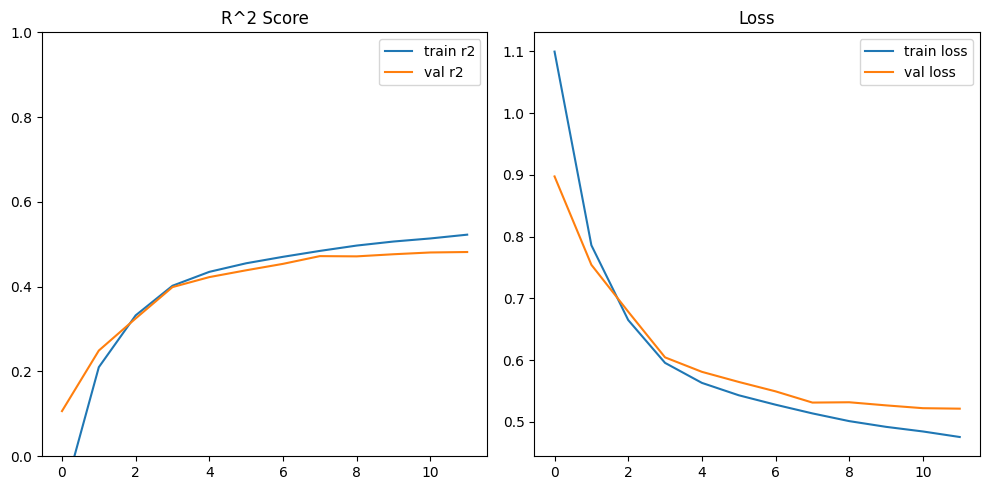

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_gammas_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images and stereo

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


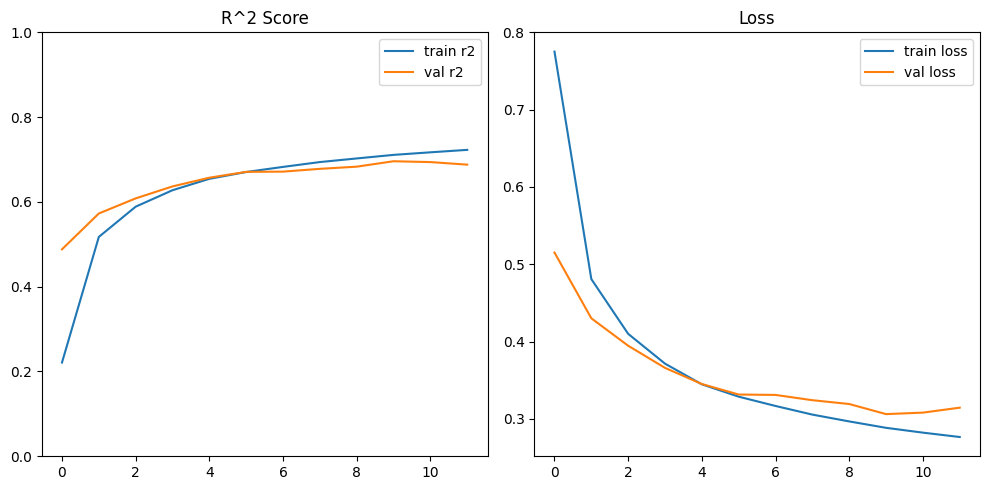

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_gammas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images, hillas and stereo

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


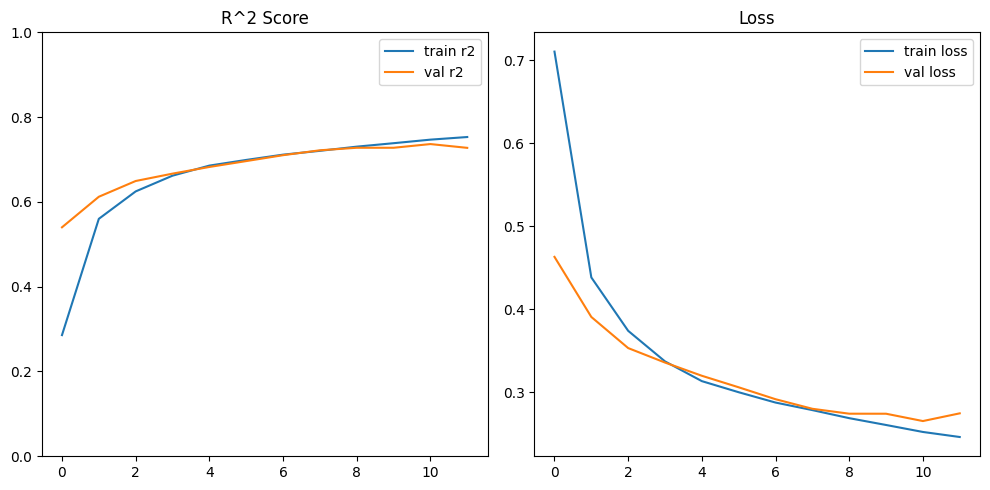

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_gammas_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

### Using MLP for protons

Since the MLP tended to overfit a bit on the proton data, some dropout was applied.

#### Using only cleaned image m1

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


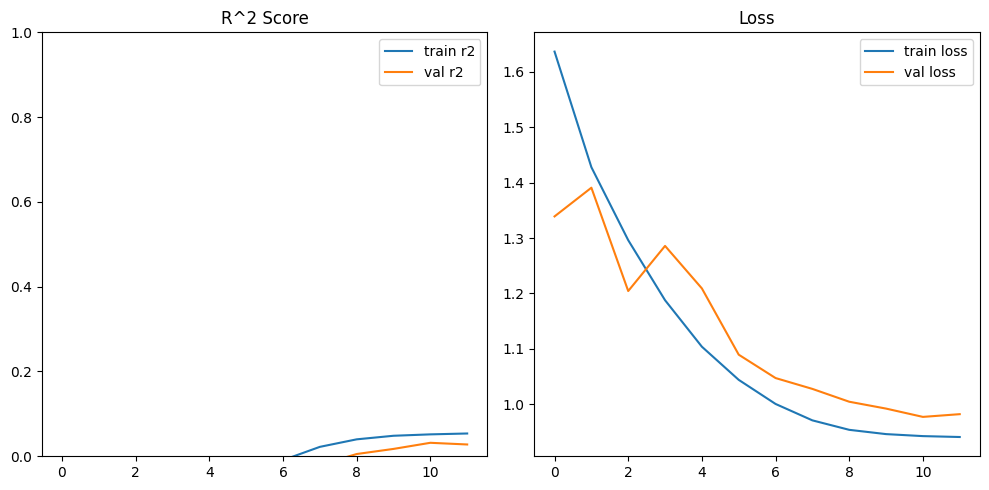

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_protons_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    dropout_rates=[0.1,0.1,0.1,0.1],
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using only cleaned image m2

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


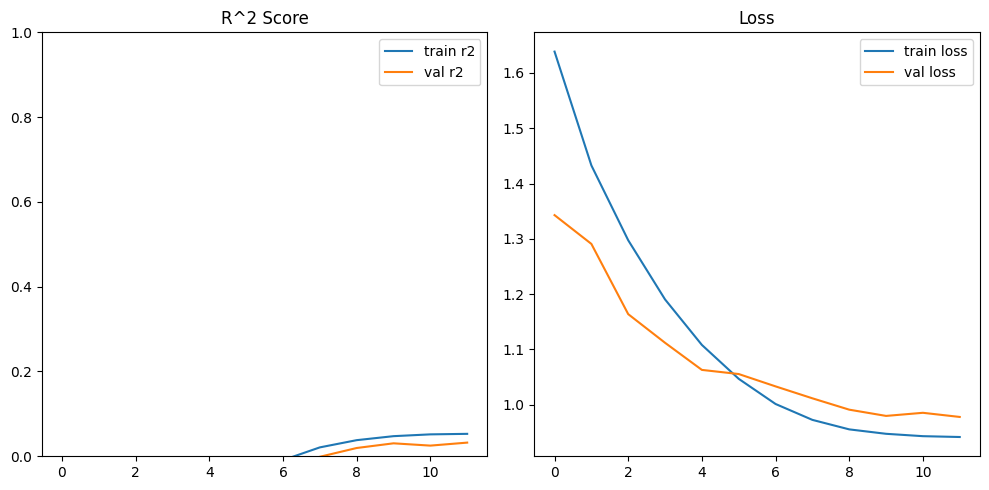

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_protons_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    dropout_rates=[0.1,0.1,0.1,0.1],
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


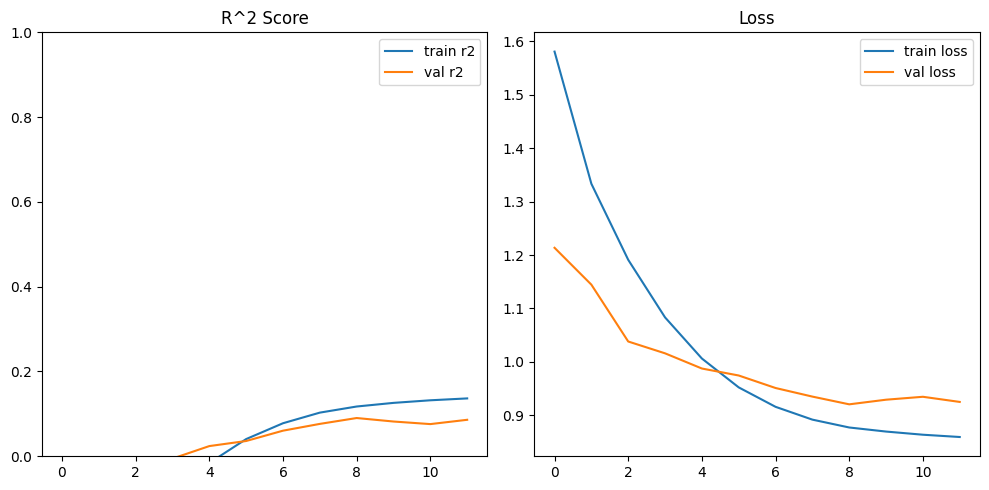

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_protons_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    dropout_rates=[0.1,0.1,0.1,0.1],
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images and hillas

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


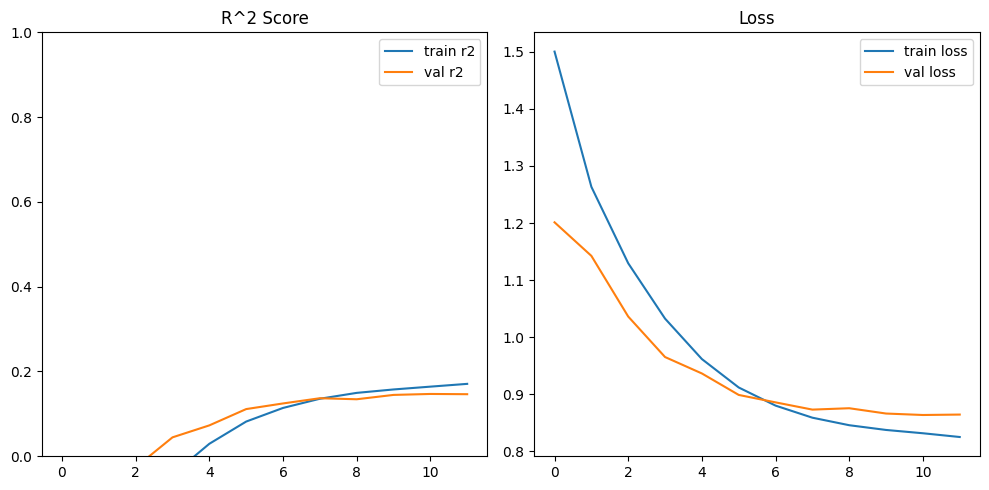

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_protons_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    dropout_rates=[0.1,0.1,0.1,0.1],
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images and stereo

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


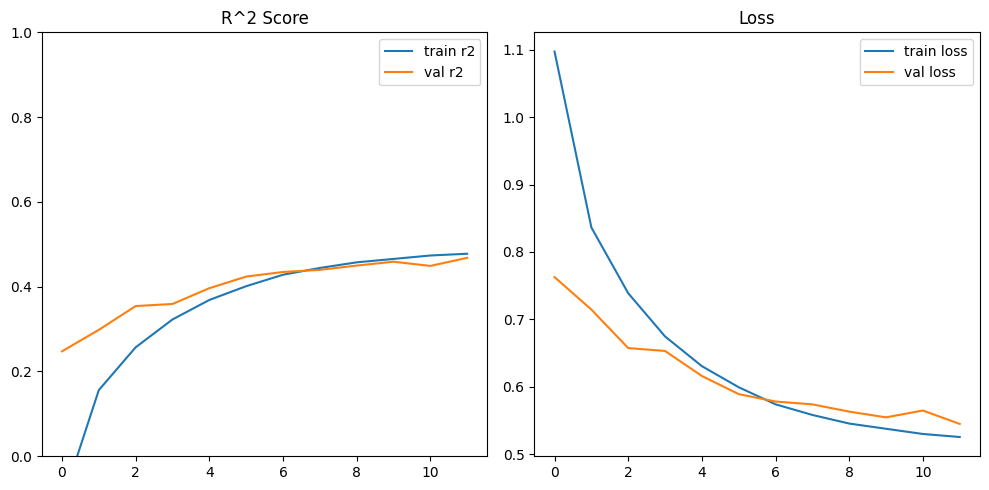

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_protons_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    dropout_rates=[0.1,0.1,0.1,0.1],
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

#### Using both cleaned images, hillas and stereo

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12


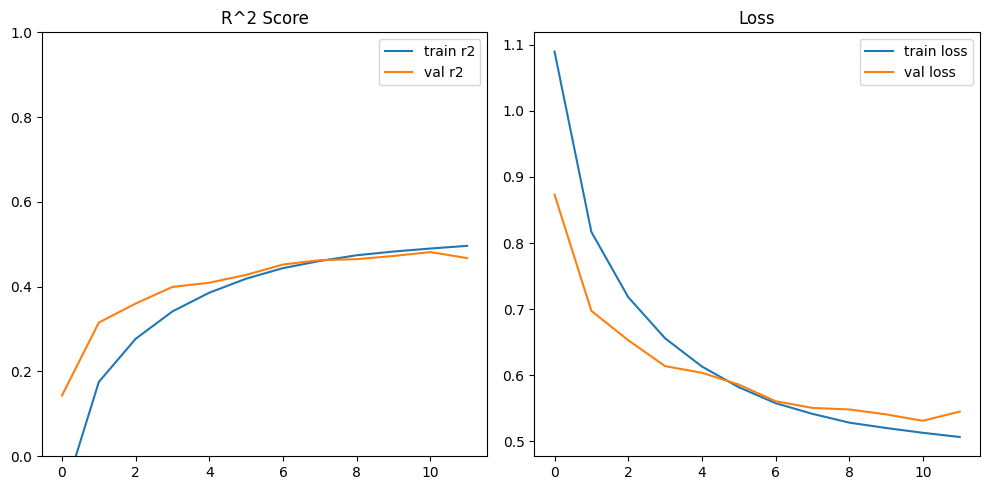

In [ ]:
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp

THIS_MODEL_NAME = "regression_mlp_protons_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_mlp.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    dropout_rates=[0.1,0.1,0.1,0.1],
    n_epochs=12,
    plot=True
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_mlp.save(model, trained_model_path)

### Using CNN for Gammas

This model uses a CNN combined with a fully-connected neural network to predict the true shower parameters. 

It has three convolutional layers that gradually expand the two-channel input (image m1 and m2) to 64 channels. ReLU activation, batch normalisation and max pooling are used. It then flattens it and appends the additional features (hillas, stereo). Three fully connected layers reduce this to an output size of eight. They use ReLU activation and batch normalisation.

#### Using only cleaned image m1

[W316 23:56:33.245595484 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


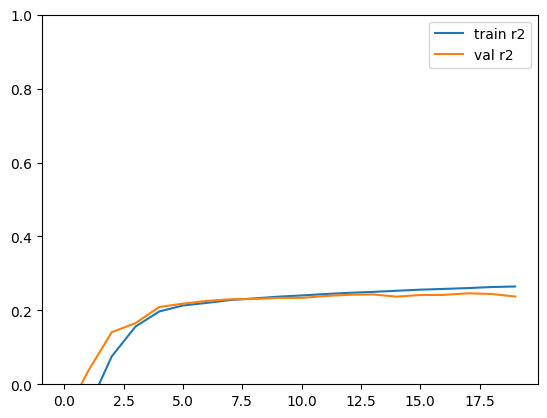

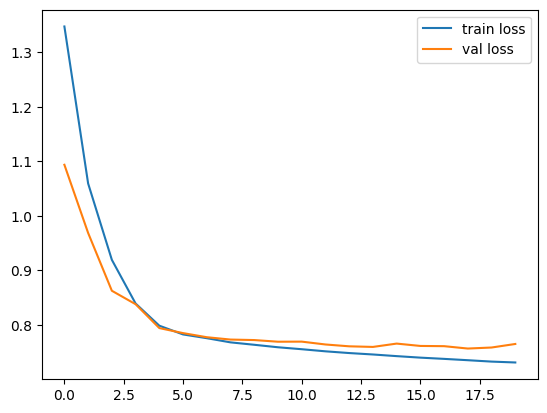

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_gammas_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=1
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using only cleaned image m2

epoch 1


epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


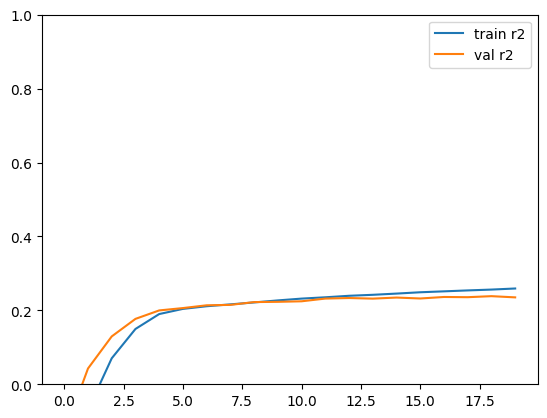

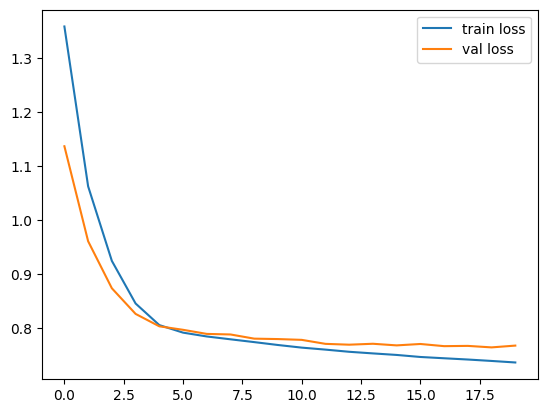

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_gammas_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=1
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


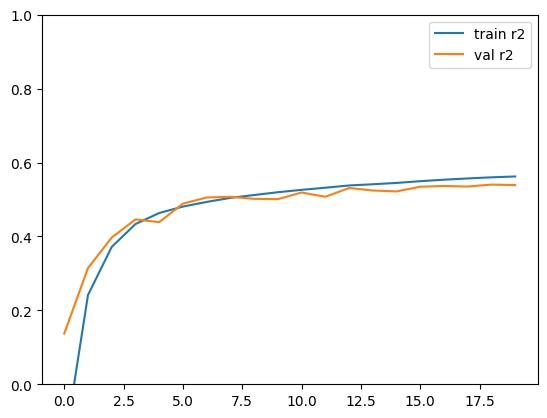

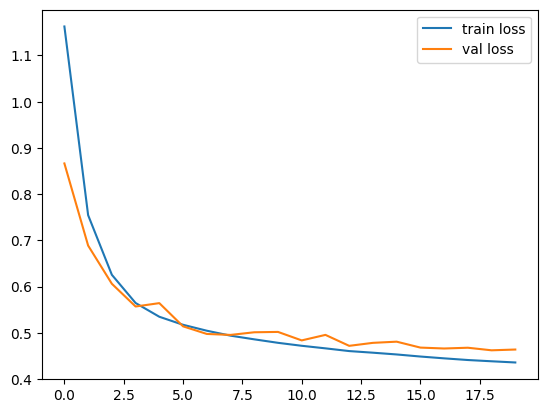

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_gammas_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=2
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images and hillas

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


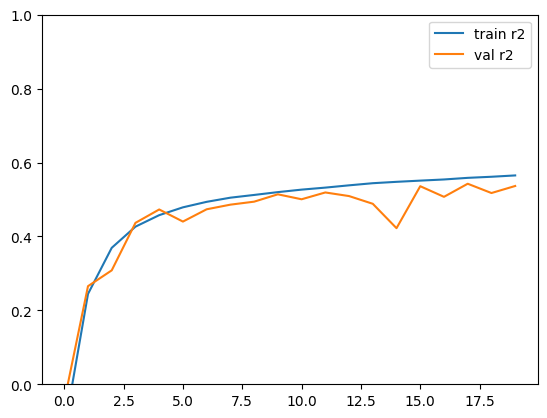

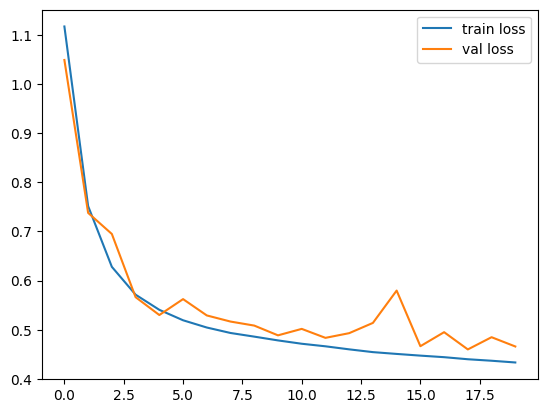

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_gammas_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=2
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images and stereo

epoch 1


epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


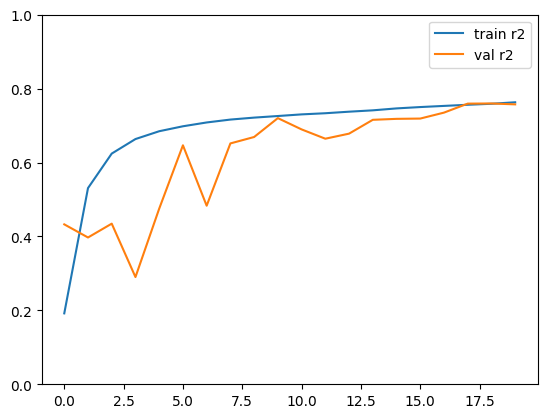

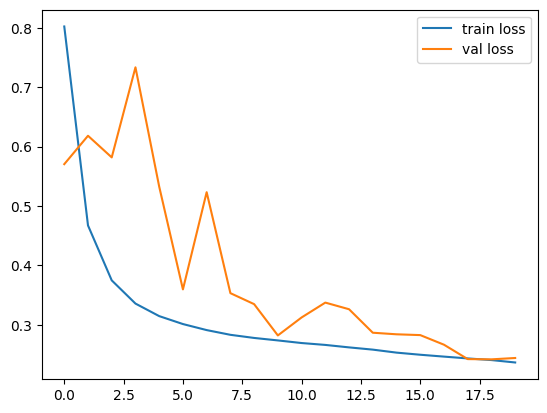

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_gammas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=2
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images, hillas and stereo

epoch 1
epoch 2


epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


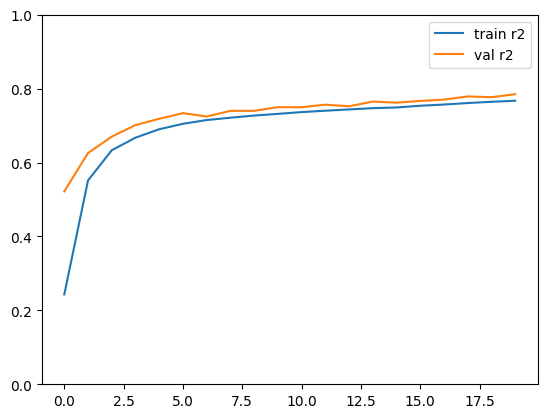

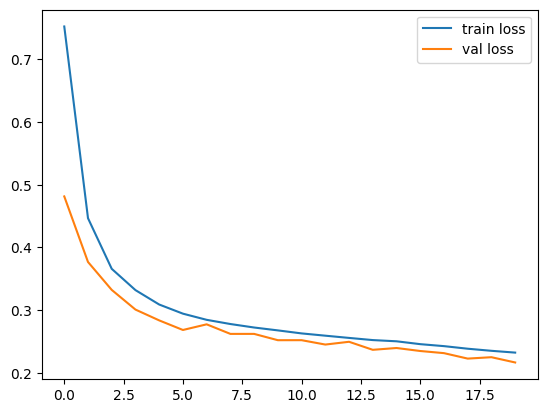

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_gammas_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

### Using CNN for Protons
#### Using only cleaned image m1

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


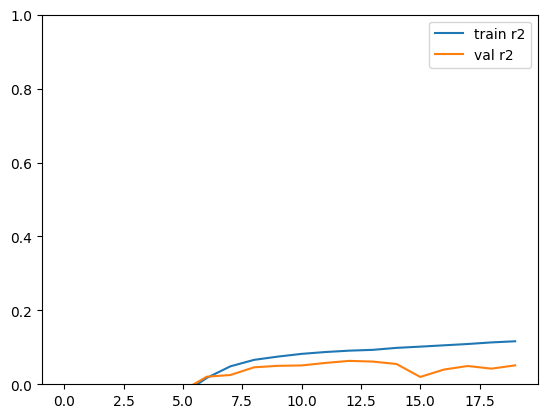

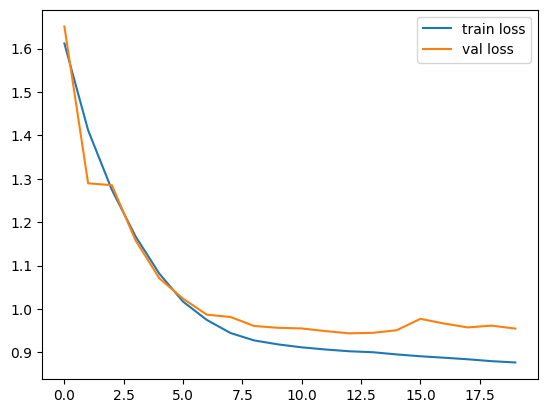

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_protons_m1"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=1
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using only cleaned image m2

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


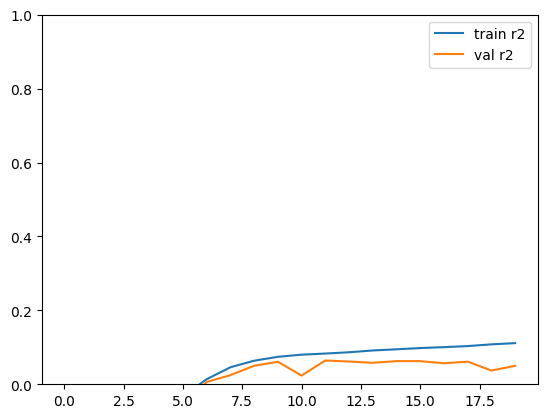

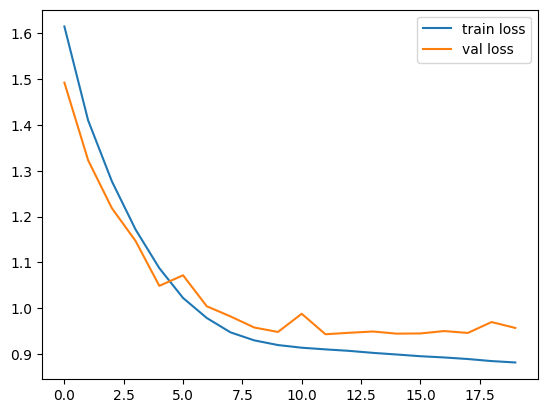

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_protons_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=1
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


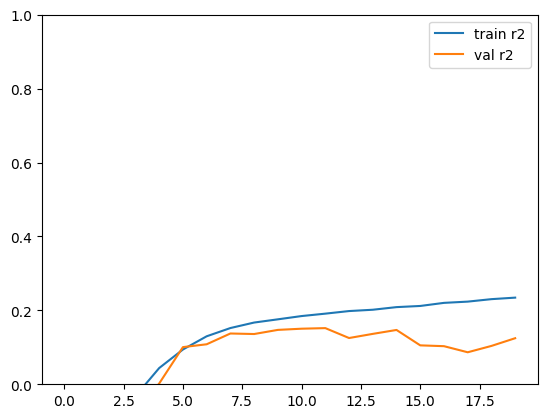

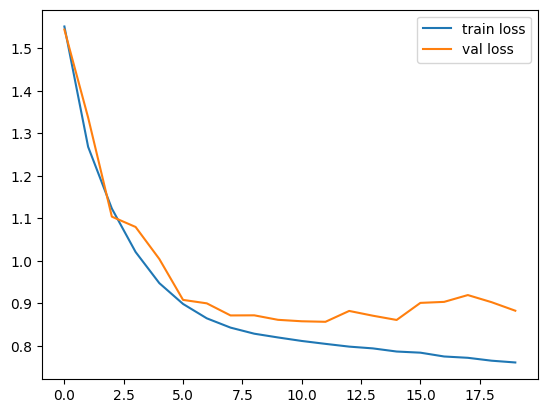

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_protons_m1_m2"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=[],
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=2
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images and hillas

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


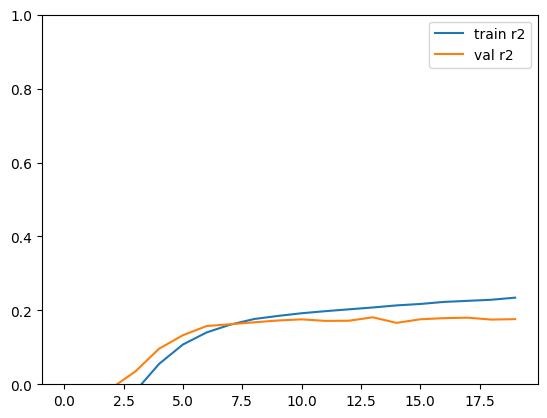

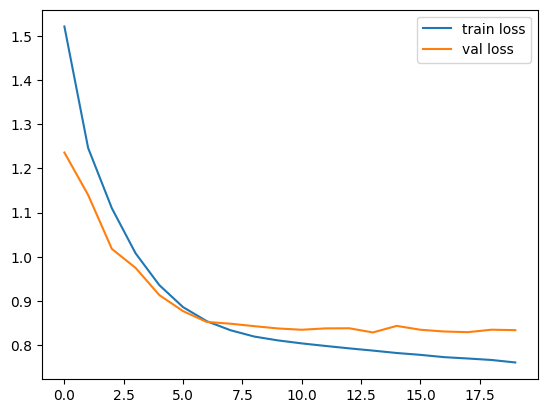

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_protons_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=2
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images and stereo

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


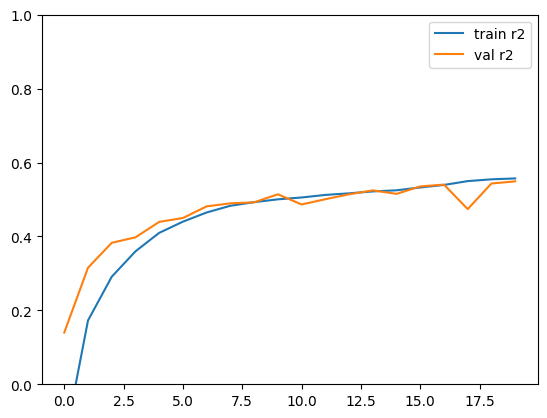

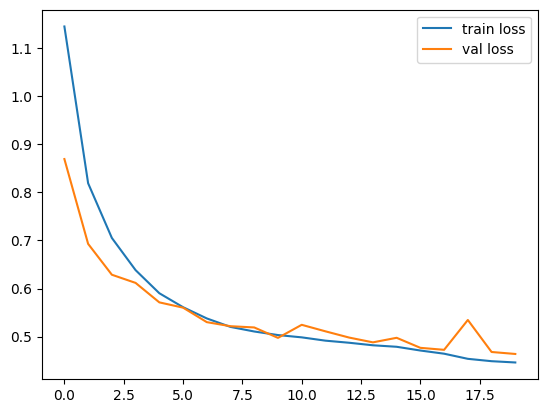

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_protons_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4,
    in_channels=2
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

#### Using both cleaned images, hillas and stereo

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


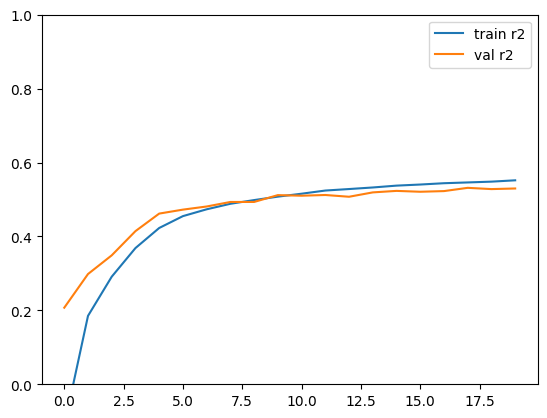

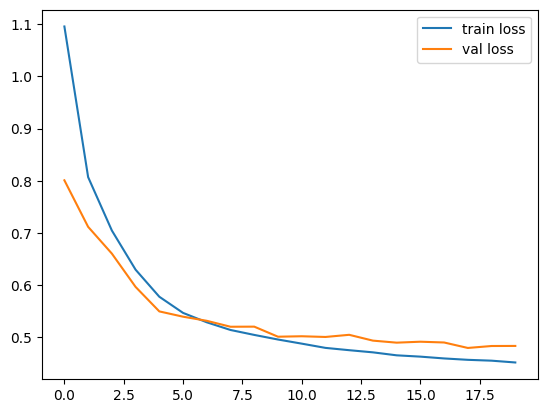

In [ ]:
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn

THIS_MODEL_NAME = "regression_cnn_protons_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = regression_cnn.train(
    data_regression_protons_train,
    data_regression_protons_validation,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    target_features=FEATURES_TRUE_SHOWER,
    device=torch_device,
    n_epochs=20,
    plot=True,
    weight_decay=1e-4
)

if SAVE_MODELS_AFTER_TRAINING:
    regression_cnn.save(model, trained_model_path)

### Comparison of regression models
#### R² comparison for gamma data

In [ ]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn
from src.common.regression_evaluate import regression_comparison

regression_comparison(
    [lin_reg, regression_dt, regression_rf, regression_mlp, regression_cnn],
    ["linear", "decisiontree", "randomforest", "mlp", "cnn"],
    data_regression_gammas_test,
    TRAINED_MODELS_DIR,
    "gammas",
    device=torch_device
)

,linear,decisiontree,randomforest,mlp,cnn
Cleaned image m1,0.05093,0.038745,0.1127,0.18321,0.240555
Cleaned image m2,0.050905,0.040445,0.11403,0.177603,0.241967
Both cleaned images,0.062409,0.041311,0.19265,0.410635,0.54638
Both cleaned images and Hillas parameters,0.204127,0.164884,0.384688,0.488683,0.540937
Both cleaned images and Stereo parameters,0.449107,0.511634,0.734603,0.691461,0.769193
"Both cleaned images, Hillas and Stereo parameters",0.535143,0.52844,0.785928,0.730425,0.785108


#### R² comparison for proton data

In [4]:
import src.infer_true_shower_parameters.baseline.linear_regression as lin_reg
import src.infer_true_shower_parameters.baseline.decision_tree_regression as regression_dt
import src.infer_true_shower_parameters.baseline.random_forest_regression as regression_rf
import src.infer_true_shower_parameters.mlp.mlp as regression_mlp
import src.infer_true_shower_parameters.cnn.cnn as regression_cnn
from src.common.regression_evaluate import regression_comparison

regression_comparison(
    [lin_reg, regression_dt, regression_rf, regression_mlp, regression_cnn],
    ["linear", "decisiontree", "randomforest", "mlp", "cnn"],
    data_regression_gammas_test,
    TRAINED_MODELS_DIR,
    "protons",
    device=torch_device
)

[W318 16:06:14.960190822 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


,linear,decisiontree,randomforest,mlp,cnn
Cleaned image m1,0.012853,0.019419,0.051717,-0.00408,-0.189308
Cleaned image m2,0.013528,0.021919,0.054811,0.000548,-0.192313
Both cleaned images,0.016685,0.018041,0.113238,0.113503,0.262983
Both cleaned images and Hillas parameters,0.049023,0.024404,0.104594,0.160112,0.236296
Both cleaned images and Stereo parameters,0.389023,0.378506,-0.120498,0.40725,0.304604
"Both cleaned images, Hillas and Stereo parameters",0.3754,0.368555,0.24913,0.42873,0.534456


#### Analysis

Overall, we see that the models operating on one-dimensional input vectors, namely the baseline models and the MLP, profit the most from having the non-image features available, especially the stereo parameters. On the other hand, the CNN is better at extracting information when only the images or only the images and the hillas parameters are available. 

We also see that all models perform worse on the proton data. This is likely due to less training data being available for protons. Another observation is that it seems that either of the cleaned images by themselves do not provide enough information to make a good prediction about the true shower parameters. This is especially true for the proton dataset, where all models are about as good as guessing or even worse when only trained on one of the two images.

One anomaly which we cannot explain is that only for the protons, (only) the random forest performs significantly worse on the test data than on the validation data. This is especially striking for the one that has been trained on both images and the stereo parameters: it achieves an R² of about 0.5 on the _validation_ data (see the training sections of these notebooks), but even a negative result on the _test_ data.

All in all, the CNN performs the best, even if the random forest is sometimes on par with it if it can use the stereo parameters.